# Part 0: Installing the environment:

There are a number of prerequisites to running the IntroUNET code used in this exercise. But hopefully it will be relatively quick and painless. Here we go:

## Step 0.1: use `conda` to create an environment for IntroUNET

First, if you don't already have the `conda` environment manager, you can use this link to install it: https://www.anaconda.com/docs/getting-started/miniconda/install

Next, let's create the conda environment that we will use for this exerecise:

```
conda create -n "introUNet" python=3.8
```

## Step 0.2: activate our environment and install the required software.

Now let's activate the environment:

```
conda activate introUNet
```

Next, we actually add the required software to this environment.

First, This exercise uses the `popgenml` GitHub repository, a Python package with some supporting functions and definitions for our inference models etc. So you will need to clone and install `popgenml`. `popgenml` also uses the forward-in-time population genetic download the time forward simulator SLiM, you you will have to install that as well if you haven't already.

First, `SLiM`:

You can install `SLiM` using `conda`:

```
conda install -c conda-forge slim
```

Or, you can install `SLiM` on Linux directly from its repository:

```
git clone https://github.com/MesserLab/SLiM.git
cd SLiM
mkdir build
cd build
cmake ..
make
sudo make install
```

Note: if you are running this on a cluster where you don't have sudo privileges the last step may fail but you can just move the resulting `slim` executable to your `/bin` directory or edit your `$PATH` variable accordingly.

If you are using MacOS you can use the Messer Lab's installer (https://messerlab.org/slim/), or again use `conda` as described above.

Next, install popgenml and its prequisites and install the machine learning library PyTorch (the latter may take some time):

```
git clone https://github.com/SchriderLab/popgenml.git
cd popgenml
pip install -r requirements.txt
python3 setup.py install

conda install pytorch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 pytorch-cuda=12.1 -c pytorch -c nvidia
```

If the conda command gives an error, try installing the packages without CUDA (GPU support):
```
conda install pytorch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 -c pytorch
```

## Step 0.3: Download some data (both simulated and empirical) to use during the exercise.

First, navigate to the `tutorials` directory in the `popgenml` repository:

```
cd tutorials
```

Then, if you are using linux, whether it be your own machine or a remote server/HPC, you can download the required data as follows.

```
wget --no-check-certificate https://figshare.com/ndownloader/files/52745468 -O data.tgz
```

Or, if you are running things locally on a Mac or Linux environment you can just use the hyperlink (https://figshare.com/ndownloader/files/52745468) and then move it to the `tutorials` directory.

Once the download is complete, simply extract the archive:

```
tar -xzf data.tgz
```

# Part 1: Simulating some training/test data with SLiM

Now we're ready to get started. First, let's open jupyter so we can actually run the code in this notebook:

```
jupyter notebook
```

Then go to the browser window that just opened, navigate to `tutorials`, open the `introUNet_tutorial.ipynb`, and in the window that opens scroll down to this part of the notebook.

Now we're ready to rock!

## Step 1.1: Using the SLiM script in `popgenml` for simulating and tracking introgression events.

Next we'll use a SLiM script to simulate some data within Python and format the inputs to our inference routine.  For reference the SLiM script is at: 

```
popgenml/popgenml/slim/introg_bidirectional.slim
```

In [1]:
from popgenml.data.simulators import SlimSimulator

sim = SlimSimulator()
sim.args

'-d sampleSizePerSubpop={} -d donorPop={} -d st={} -d mt={}'

The ```SlimSimulator``` class has various arguments that must be passed to it to simulate: the number of samples per subpopulation the 'donor' pop or the population that individuals migrate from forward in time, and split time and migration time coefficients.  Let's simulate a replicate with 64 haploid genomes per subpopulation (first argument = 64), gene flow from population 1 to population 2 (second argument = 1), a population split time of 4N generations ago (third argument = 4), and gene flow occuring 0.25*4N=N generations ago (fourth argument = 0.25):

In [2]:
x, pos, y = sim.simulate(64, 1, 4, 0.25)

print(x.shape)
print(y.shape)

migTime: 11654
migProb: 0.490221
migProbs: 0.490221, 0


(128, 1970)
(128, 1970)


### Visualizing input

The simulation command above gives us a genotype matrix where each row is a chromosome from our sample (with the first 64 in pop A, and the last 64 in pop B) and each column represents a polymorphism at some position referenced in the array ```pos```.  We also get another matrix of equal size that is an introgression mask telling us which polymorphisms and individuals have introgressed alleles from the other population.  Lets plot them to see what they look like:

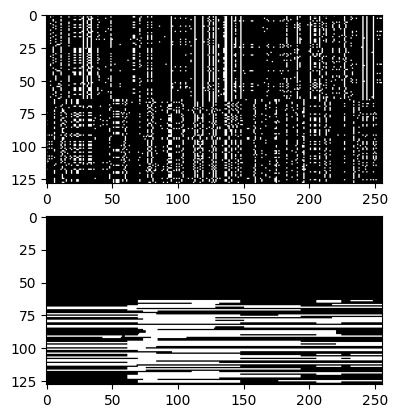

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2)

axes[0].imshow(x[:,:256], cmap = 'gray')
axes[1].imshow(y[:,:256], cmap = 'gray')

plt.show()

## Step 1.2 Formatting our inputs:

First we'll format the input to our inference routine which is the genotype matrix.  We will be using a CNN or Convolutional Neural Network that operates on images.  Color images on a computer are usually represented by 3d arrays of the shape (3, height, width) where there are 3 channels for red/green/blue values.  Here, we already have a 2d array with 1 channel for whether or not an individual has the mutation at a given site. Currently, however, the sample of individuals has no specific order--i.e. shuffling the order of rows in our genotype matrix does not change its meaning. Since convolutions operate on spatially local features this might not be ideal. Since we have two samples of the same size and they are labeled (pop A and pop B), it might be advantageous to give them separate channels in the image as well. We have found that different strategies to ordering the individuals in these two population samples impacts our accuracy for detecting introgression. Below, we describe the best approach we have identified for this so far 

### Sorting the first population via seriation

We begin by sorting one of the two populations, which we will call the "first population". Which population should be sorted first? We have found that it is better to sort the more diverse population first, but if the two populations are very similar in this respect, as is the case in this simulated dataset, the choice is arbitrary.

Let's order individuals in first population using seriation (source: https://github.com/src-d/seriate/tree/master). Seriation is the name of an algorithm that solves the travelling salesman problem, or how to order destinations such that when travelling to all of them you do so in the smallest distance.  Here is an example where we start out with the randomly shuffled rows of an image and use the seriation algorithm to piece it back together:

![Alt Text](https://github.com/src-d/seriate/blob/master/doc/example.png?raw=true "example")

The first step in seriation involves computing the distance between any pair of rows in our matrix.  We'll do this for a small window (128 SNPs) of the genome:

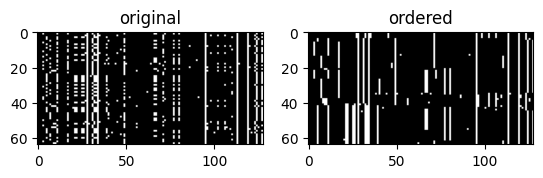

In [4]:
from seriate import seriate
from scipy.spatial.distance import pdist, cdist, squareform

x1 = x[:64,:128] # first sub population, first 128 snps
x2 = x[64:,:128] # second sub population, first 128 snps

# compute a square distance matrix (using the cosine distance matrix)
D = squareform(pdist(x1, metric = 'cosine'))

# order the rows via seriation -- thankfully google's ortools does this for us
ii = seriate(D, timeout = 0.) # timeout = 0. means go to convergence no matter what
x1_ordered = x1[ii] # order the first subpop

# plot the results
fig, axes = plt.subplots(ncols = 2)
axes[0].imshow(x1, cmap = 'gray')
axes[1].imshow(x1_ordered, cmap = 'gray')
axes[0].set_title('original')
axes[1].set_title('ordered')
plt.show()

### Linear cost matching

Now that we have sorted the first population sample for this genomic window, which will make up the first channel of our input tensor, we need to decide what the order of the second population sample will be. We could just sort it in the same way, but we have found that it is better to somehow match individuals between the two populations. The rationale is fairly simple: if there is introgression, then we might expect the most simliar pairs of individuals between the two populations to be very similar indeed, while in the absence of introgression they might look quite different. So if we try to match individuals from population 2 to their most similar counterparts from population 1, our convolution operations might be able to identify regions of elevated similarity. That is the rationale anyway, and the approach seems to work.

Anyway, the algorithm we have chosen to do this is linear cost matching.  This algorithm takes two groups of items and matches them together using some cost matrix such that the total cost or the sum of the entries chosen is minimized.  

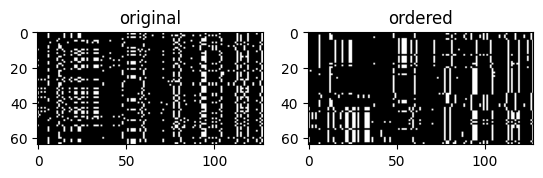

In [5]:
from scipy.optimize import linear_sum_assignment
import numpy as np

# compute the distance matrix from element i in x1_ordered to element j in x2
D2 = cdist(x1_ordered, x2, metric = 'cosine')

# compute the matching via scipy (we can assume the first indices are just (0,1,2,...))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html
_, ii2 = linear_sum_assignment(D2)

x2_ordered = x2[ii2]

# plot the results
fig, axes = plt.subplots(ncols = 2)
axes[0].imshow(x2, cmap = 'gray')
axes[1].imshow(x2_ordered, cmap = 'gray')
axes[0].set_title('original')
axes[1].set_title('ordered')
plt.show()

Now we can create a 2-channel image from these matrices:

In [6]:
x = np.concatenate([np.expand_dims(x1_ordered, 0), np.expand_dims(x2_ordered, 0)], 0)
x.shape

(2, 64, 128)

# Part 2: Creating a model for identifying introgressed loci

## Step 2.1: Borrowing the ResNet architecture.

Now that we have an idea of what are inputs are like, we want to define an inference model and attempt to predict whether a given window of chromosome contains introgressed alleles.  We start by defining a neural network architecture, which we could design from the ground up. Often however it is just as effective to use an existing architecture, and we have found that to be the case for this problem. Here, we will use the popular CNN architecture called ResNet.  Our implementation is no different from the one given in the torchvision Python package other than we change the number of input channels from 3 to 2. We define it as follows:

In [7]:
from popgenml.models.torchvision_mod_layers import resnet34
import torch

model = resnet34(in_channels = 2, num_classes = 2)
x = torch.FloatTensor(x).unsqueeze(0)
print(x.shape)

y_pred = model(x)
print(y_pred.shape)

torch.Size([1, 2, 64, 128])
torch.Size([1, 2])


Here we forwarded one example image through our model to get a prediction.  The prediction in this case is meant to give an estimate of the posterior probability, given the genotype array, that the window contains introgressed alleles.  There are two entries each with a score corresponding to no introgression and introgression respectively.  The vector can be converted into probabilities that sum to 1 via the softmax function.

## Step 2.2 Using a larger simulated dataset for training and testing our introgression detector

Now that you know how to simulate and format input images for our introgression detector, you could simulate an entire dataset for training and testing. But that could take a while, so we have saved you the effort by pre-cooking some simulated data for this purpose. Let's look at the data sample we provide and go through the process of using it to train our classifier.

In [8]:
import os
print(os.listdir('data'))
print(os.listdir('data/ab')[:5])

['ab', 'drosophila_data', 'none']
['09664.npz', '06557.npz', '01238.npz', '07891.npz', '00126.npz']


Each directory contains a number of .npz files which each have two keys ('x' and 'y') that point to a mini-batch of four example windows of simulated chromosomes that are already sorted and formatted in the way we did our single example. Let's take a look at one of these files:

In [9]:
ifile = np.load('data/ab/03041.npz')
x = ifile['x']
y = ifile['y']

print(x.shape)
print(y.shape)

(4, 2, 64, 128)
(4, 1, 64, 128)


## Writing a data loader class

To train our CNN classifier, we need to be able to read in data in minibatches that we will use to perform gradient descent to optimize the CNN's weights. To do this in PyTorch, we have to write a DataLoader, a small class that will randomly sample data from the included NPZ files for training our inference model.

Our input are the two channel images we've created, and in this case our target is simply 0 or 1 corresponding to no-introgression and introgression respectively.  Note that we randomly save 1% of the data to use for testing (this is maybe too small a proportion in practice, but is chosen here for brevity).

In [19]:
import glob
import random
import copy

class DataLoader(object):
    def __init__(self, idir = 'data', val_prop = 0.01):
        self.idir = idir
        self.classes = sorted([d for d in os.listdir(self.idir) if d != "drosophila_data"], reverse = True)
        print(self.classes)
        
        self.n_per = 1

        self.ifiles = dict()
        self.ifiles_val = dict()
        
        for c in self.classes:
            self.ifiles[c] = glob.glob(os.path.join(idir, os.path.join(c, '*.npz')))

            random.shuffle(self.ifiles[c])
            n_val = int(val_prop * len(self.ifiles[c]))

            self.ifiles_val[c] = self.ifiles[c][:n_val]
            del self.ifiles[c][:n_val]

    
    def get_batch(self, n_per = 1):
        X = []
        y = []

        # make balanced batches
        for ix, c in enumerate(self.classes):
            for ij in range(n_per):
                ifile = self.ifiles[c][np.random.choice(range(len(self.ifiles[c])))]

                x = np.load(ifile)['x']
    
                X.extend(x)
                y.extend([ix for u in range(x.shape[0])])

        X = torch.FloatTensor(np.array(X))
        y = torch.LongTensor(np.array(y))
            
        return X, y

    def get_validation_data(self):
        X = []
        y = []

        # make sure the validation dataset is balanced too
        L = min([len(self.ifiles_val[u]) for u in self.classes])

        for ix, c in enumerate(self.classes):
            for ij in range(L):
                ifile = self.ifiles[c][ij]
                x = np.load(ifile)['x']
    
                X.extend(x)
                y.extend([ix for u in range(x.shape[0])])

        X = torch.FloatTensor(np.array(X))
        y = torch.LongTensor(np.array(y))
            
        return X, y
                

loader = DataLoader()

x, y = loader.get_batch()

['none', 'ab']


## Training

To optimize our CNN, we define our loss function (the error function we wish to minimize) and optimizer.  The loss function defines the problem and the gradient of our inference model w.r. to our binary targets, and the optimizer tells us how to use the gradient to update the weights. We adopt fairly standard choices for our loss function and optimizer: categorical cross entropy, and Adam, respectively.

at step 0, have acc of 0.625...
at step 25, have acc of 0.48...
at step 50, have acc of 0.705...
at step 75, have acc of 0.825...
at step 100, have acc of 0.835...
at step 125, have acc of 0.815...
at step 150, have acc of 0.875...
at step 175, have acc of 0.855...
at step 200, have acc of 0.915...
at step 225, have acc of 0.895...


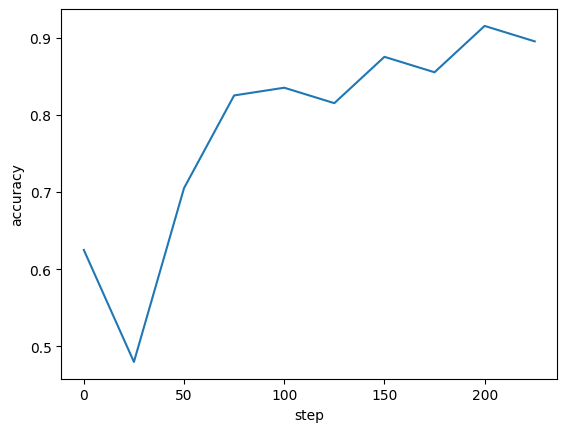

In [20]:
from torch import nn
from sklearn.metrics import accuracy_score
from scipy.special import expit

criterion = nn.CrossEntropyLoss() # loss fn
# a popular choice of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 

# turn on trainable normalization, dropout, etc.
model.train()

from collections import deque

# take a running mean of accuracies
accuracies = deque(maxlen = 25)

mean_acc = []
step = []

for ix in range(250):
    # zero any gradients from last loop
    optimizer.zero_grad()

    x, y = loader.get_batch()

    # forward our inputs and get a prediction
    y_pred = model(x)

    # compute the loss (how well did we do?)
    loss = criterion(y_pred, y)
    # compute the gradient w.r. to loss (how do we do better?)
    loss.backward()
    # update the model parameters s.t. we do better
    optimizer.step()

    # convert from Tensor to numpy array for some other metrics (just acc here)
    y = y.detach().cpu().numpy().flatten()
    # in this case our prediction is the largest score
    y_pred = np.argmax(y_pred.detach().cpu().numpy(), -1)

    accuracies.append(accuracy_score(y, y_pred))

    if ix % 25 == 0:
        print('at step {}, have acc of {}...'.format(ix, np.mean(accuracies)))
        mean_acc.append(np.mean(accuracies))
        step.append(ix)

plt.plot(step, mean_acc)
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()
plt.close()

## Testing our accuracy

Now let's run our model in inference mode to check that it generalizes to data it hasn't seen.

We will evaluate this first by examining the confuion matrix, which just shows the fraction of introgressed and non-introgressed examples that are properly classified when using our default classification threshold (i.e. 50%, so that the most probable class is our prediction).

torch.Size([792, 2, 64, 128]) torch.Size([792])


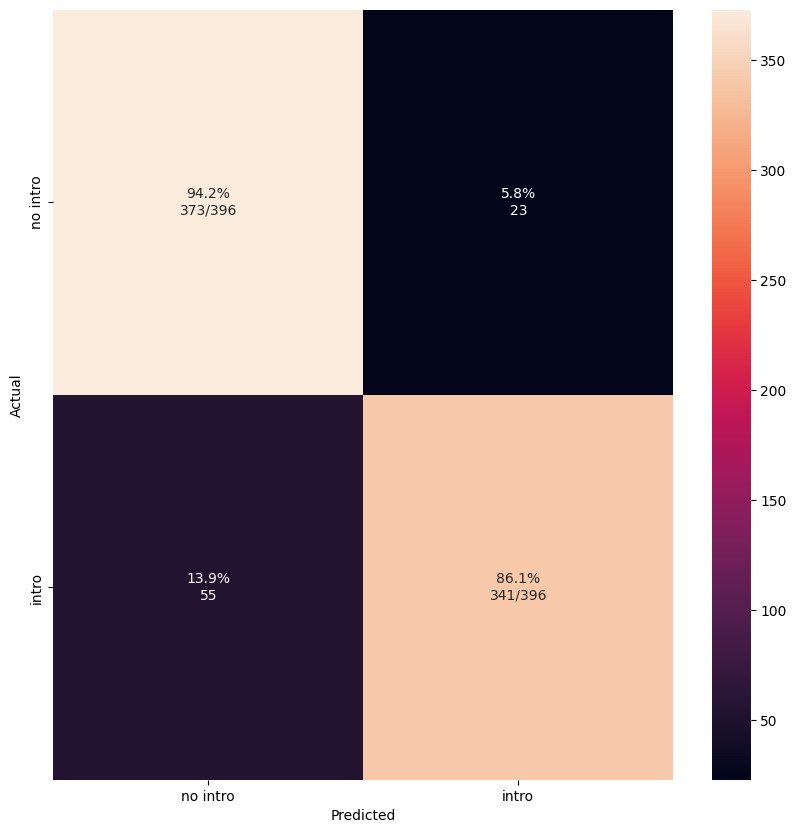

In [21]:
from popgenml.models.viz import plot_confusion_matrix

# we will predict on the validation data in chunks
# to prevent running out of RAM
def chunks(lst, n):
    ret = []
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        ret.append(lst[i:i + n])

    return ret

# we do this to disable some normalization layers that behave differently during training
model.eval()

Xval, yval = loader.get_validation_data()
print(Xval.shape, yval.shape)

indices = chunks(range(Xval.shape[0]), 32)

Y = []
Y_score = []
Y_pred = []

for ii in indices:
    x = Xval[ii]
    y = yval[ii]

    # we don't need the gradient during evaluation
    # tell Torch to turn off grad tracking and computation
    with torch.no_grad():
        y_pred = model(x)

        y = y.detach().cpu().numpy().flatten()
        Y_score.extend(y_pred.detach().cpu().numpy())
        y_pred = np.argmax(y_pred.detach().cpu().numpy(), -1)

        Y.extend(y)
        Y_pred.extend(y_pred)
    
plot_confusion_matrix(Y, Y_pred, labels = ['no intro', 'intro'])


Let's plot some more metrics to get a more complete sense of the model's performance and how it may change with different classification thresholds. We'll plot the receiver operating characteristic (ROC) curve and the precision recall curve.

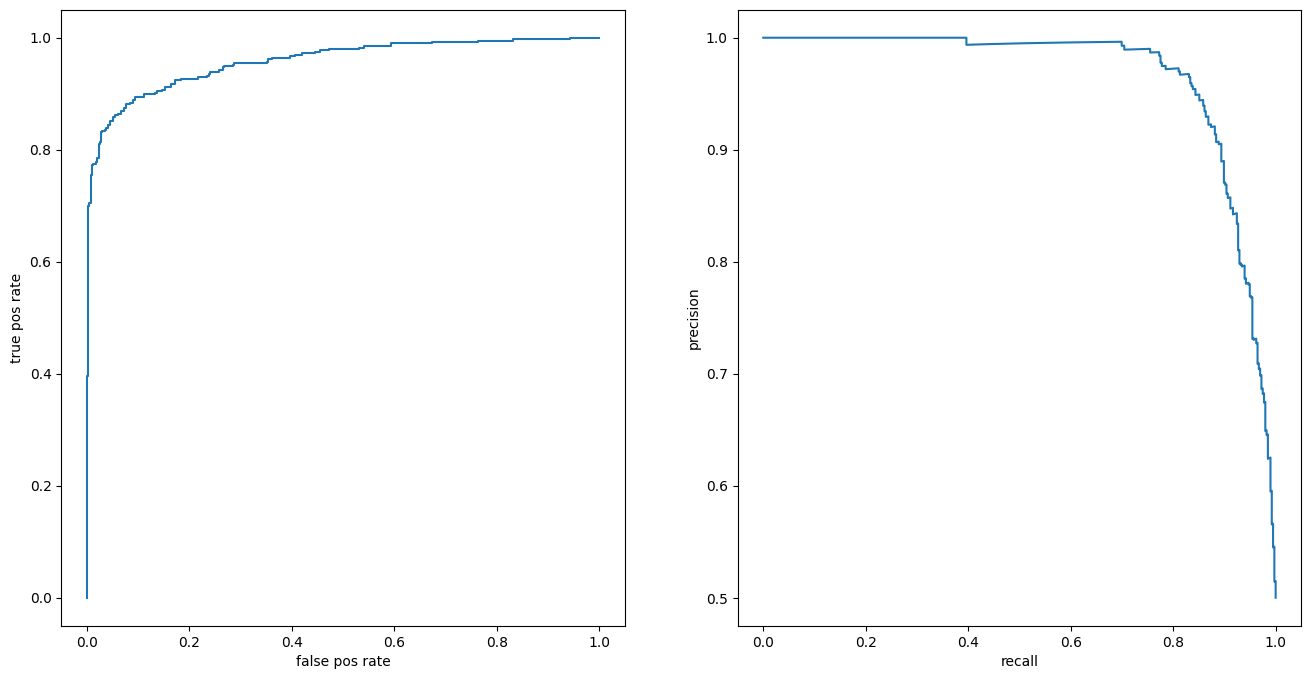

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve
Y_score = np.array(Y_score)

fpr, tpr, thresholds = roc_curve(Y, Y_score[:,-1])
precision, recall, thresholds = precision_recall_curve(
    Y, Y_score[:,-1])

fig, axes = plt.subplots(ncols = 2, figsize = (16, 8))

axes[0].plot(fpr, tpr)
axes[0].set_xlabel('false pos rate')
axes[0].set_ylabel('true pos rate')

axes[1].plot(recall, precision)
axes[1].set_xlabel('recall')
axes[1].set_ylabel('precision')
plt.show()

# Part 3: Creating and training a UNet model for identifying introgressed haplotypes

Next we get to the more challenging inference task: predicting which alleles in which individuals are introgressed, or predicting the introgression mask returned from our SLiM simulations.  For this we'll use a type of neural network called a U-Net or image-to-image network as both our input and desired output are images.  In this case our input is the same ordered and matched genotype matrix for the two populations and our desired output is a single channel image that is our introgression mask.  In this case, like the CNN, we output raw logistic scores rather than probabilities for each pixel. We can use the sigmoid function to convert our score to a probability.

## Defining the model

In [23]:
from popgenml.models.unet import NestedUNet

unet_model = NestedUNet(num_classes = 1, input_channels = 2, channel_multiplier = 2)

print(unet_model)

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv0_0): ResBlock(
    (convs): ModuleList(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (norms): ModuleList(
      (0-1): 2 x Sequential(
        (0): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): Dropout2d(p=0.1, inplace=False)
      )
    )
    (activation): ELU(alpha=1.0)
  )
  (conv1_0): ResBlock(
    (convs): ModuleList(
      (0-1): 2 x Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (norms): ModuleList(
      (0-1): 2 x Sequential(
        (0): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): Dropout2d(p=0.1, inplace=False)
      )
    )
   

## Writing a data loader

Not very interesting, so not much to say here:

In [24]:
import glob
import random
import os
import torch
import numpy as np

class UDataLoader(object):
    def __init__(self, idir = 'data/ab', val_prop = 0.01):
        self.idir = idir

        self.ifiles = glob.glob(os.path.join(idir, '*.npz'))
        random.shuffle(self.ifiles)

        n_val = int(len(self.ifiles) * val_prop)

        self.ifiles_val = self.ifiles[:n_val]
        del self.ifiles[:n_val]

    def get_batch(self, n_per = 2):
        X = []
        y = []

        for ij in range(n_per):
            ifile = self.ifiles[np.random.choice(range(len(self.ifiles)))]
    
            x = np.load(ifile)['x']
            y_ = np.load(ifile)['y']

            X.extend(x)
            y.extend(y_)

        return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y))

    def get_validation_data(self):
        X = []
        y = []

        for ij in range(len(self.ifiles_val)):
            ifile = self.ifiles_val[ij]
    
            x = np.load(ifile)['x']
            y_ = np.load(ifile)['y']

            X.extend(x)
            y.extend(y_)

        return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y))
        

unet_loader = UDataLoader()
x, y = unet_loader.get_batch()


print(x.shape, y.shape)

torch.Size([8, 2, 64, 128]) torch.Size([8, 1, 64, 128])


## Weighting the loss function

In the last case we explicitly made the DataLoader class such that the number of positive and negative examples would be equal during training.  In this case, there may be far more positive examples (pixels) than negative or vice-versa.  If this is the case, then we must weight our loss function such that the model is not biased to give a certain answer.  To do so we must know the proportion of negative to positive 'pixels' in our introgression mask.

In [25]:
ratios = []

for ifile in unet_loader.ifiles:
    y = np.load(ifile)['y']

    pos = np.sum(y)
    neg = np.prod(y.shape) - pos

    ratios.append(neg / pos)

weight = np.mean(ratios)

print(weight)

4.497808108875853


We can see that positive pixels are outnumbered by negative ones by a factor of about 4.5.  This will be the weight we apply to positive examples to balance the loss function.

## Training

In [26]:
device = torch.device('cpu')

from torch import nn
from collections import deque
from scipy.special import expit
from sklearn.metrics import accuracy_score

# Cross entropy loss without the Sigmoid function
# takes raw logistic scores
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.ones(1).to(device) * weight)
unet_optimizer = torch.optim.Adam(unet_model.parameters(), lr = 1e-3)

unet_model = unet_model.to(device)

accuracies = deque(maxlen = 25)

unet_model.train()

mean_acc = []
step = []

for ix in range(250):
    unet_optimizer.zero_grad()

    x, y = unet_loader.get_batch(2)

    x = x.to(device)
    y = y.to(device)
    
    y_pred = unet_model(x)
    loss = criterion(y_pred, y.squeeze())
    loss.backward()
    unet_optimizer.step()

    y = y.detach().cpu().numpy().flatten()
    y_pred = np.round(expit(y_pred.detach().cpu().numpy().flatten()))

    accuracies.append(accuracy_score(y, y_pred))

    if ix % 25 == 0:
        print('at step {}, have acc of {}...'.format(ix, np.mean(accuracies)))
        mean_acc.append(np.mean(accuracies))
        step.append(ix)
    

at step 0, have acc of 0.5843353271484375...
at step 25, have acc of 0.6626776123046875...
at step 50, have acc of 0.7044964599609375...
at step 75, have acc of 0.771873779296875...
at step 100, have acc of 0.788660888671875...
at step 125, have acc of 0.772760009765625...
at step 150, have acc of 0.7818487548828125...
at step 175, have acc of 0.7691961669921875...
at step 200, have acc of 0.7769586181640625...
at step 225, have acc of 0.800494384765625...


## Testing

First let's plot some example predictions side-by-side with the true introgression masks from our teat set.

In [27]:
Xval, yval = unet_loader.get_validation_data()

# convert y to numpy
yval = yval.detach().cpu().numpy()

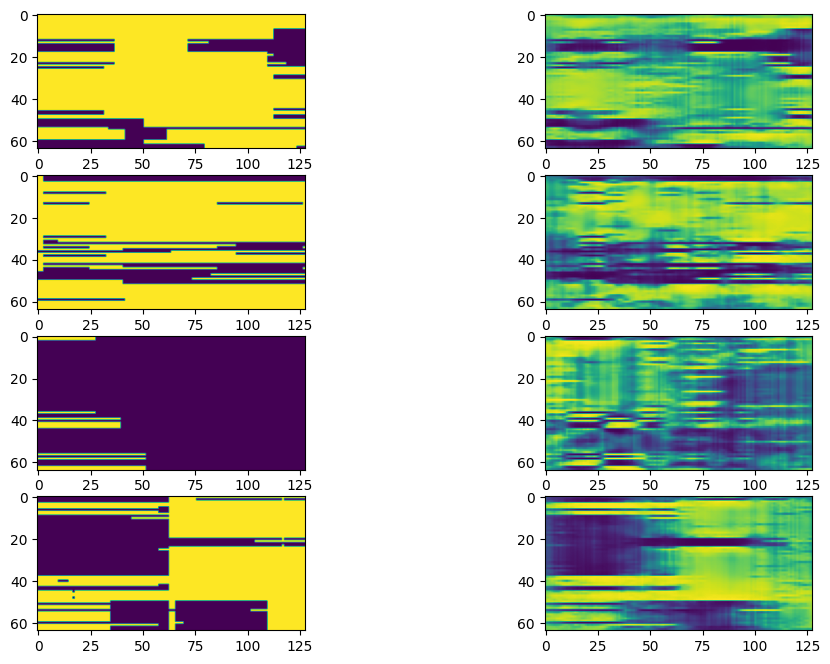

In [28]:
X = Xval[:4]

model.eval()
with torch.no_grad():
    y_pred = unet_model(X).detach().cpu().numpy()

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 8))
for k in range(4):
    axes[k, 0].imshow(yval[k,0,:,:])
    axes[k, 1].imshow(expit(y_pred[k,:,:]))

plt.show()

Now let's plot a confusion matrix for a part of the test set.

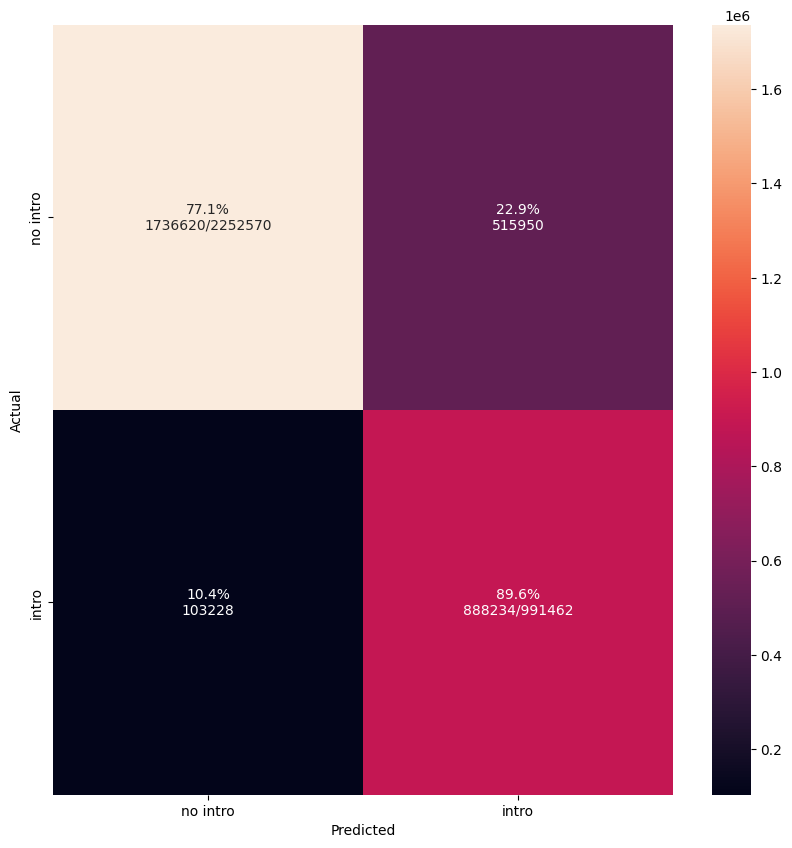

In [29]:
from popgenml.models.viz import plot_confusion_matrix

def chunks(lst, n):
    ret = []
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        ret.append(lst[i:i + n])

    return ret

# chunk the validation set (might run out of RAM trying to forward the whole thing)
indices = chunks(range(Xval.shape[0]), 32)

Y = []
Y_score = []
Y_pred = []

for ii in indices:
    x = Xval[ii]
    y = yval[ii]

    # we don't need the gradient during evaluation
    # tell Torch to turn off grad tracking and computation
    with torch.no_grad():
        y_pred = unet_model(x)

        y = y.flatten()
        Y_score.extend(y_pred.detach().cpu().numpy().flatten())
        y_pred = np.round(expit(y_pred.detach().cpu().numpy().flatten()))

        Y.extend(y)
        Y_pred.extend(y_pred)
    
plot_confusion_matrix(Y, Y_pred, labels = ['no intro', 'intro'])

And similarly let's plot the ROC and precision recall curves, same as last time:

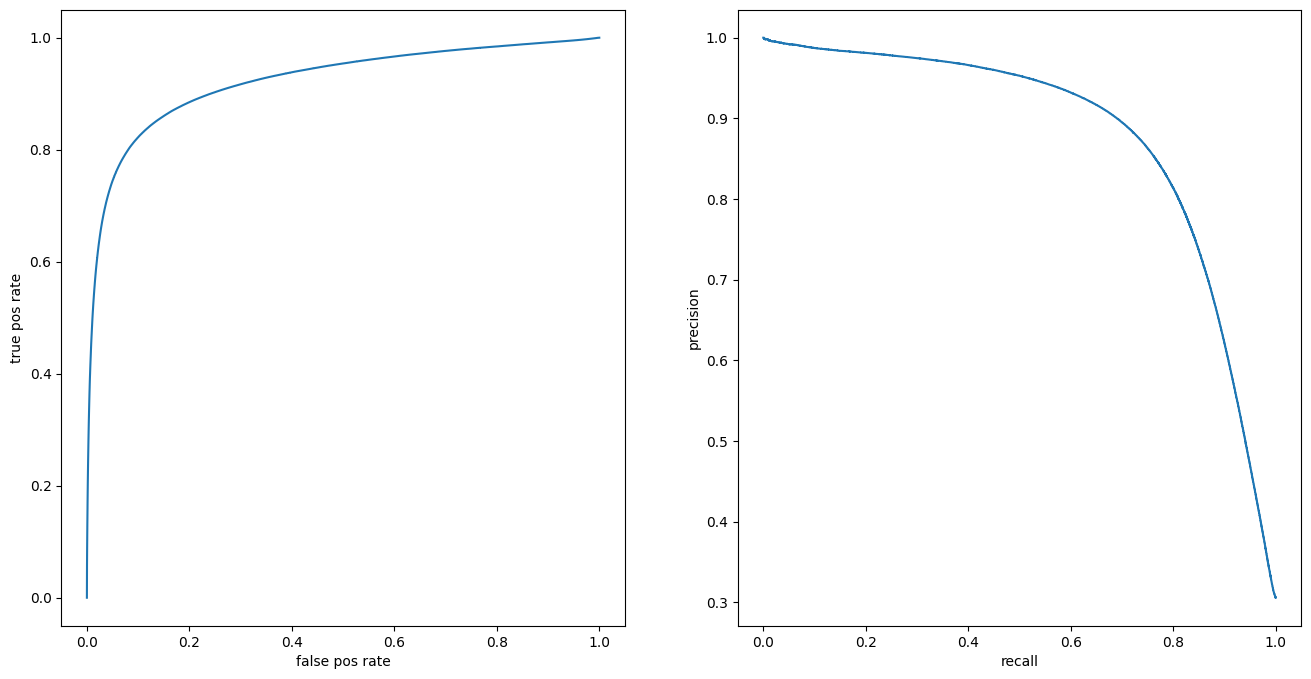

In [30]:
from sklearn.metrics import roc_curve, precision_recall_curve
Y_score = np.array(Y_score)

fpr, tpr, thresholds = roc_curve(Y, Y_score)
precision, recall, thresholds = precision_recall_curve(
    Y, Y_score)

fig, axes = plt.subplots(ncols = 2, figsize = (16, 8))

axes[0].plot(fpr, tpr)
axes[0].set_xlabel('false pos rate')
axes[0].set_ylabel('true pos rate')

axes[1].plot(recall, precision)
axes[1].set_xlabel('recall')
axes[1].set_ylabel('precision')
plt.show()

## Some notes

In practice you'll need to validate your model during training and train until convergence or until the model no longer improves on validation or data not used to define the gradient i.e. during training.  In this notebook we only train briefly and so our models don't have time to overfit, but it is possible that performance would have been better had we continued for longer (or stopped sooner). A validation set would help us figure that out.

# Part 4: Analysing the frequencies of introgressed alleles in *D. sechellia* using IntroUNET

This portion of the notebook takes us through the steps of analyzing the results from running IntroUNET on our *D. simulans* and *D. sechellia* data set. Before we start here, we have already run IntroUNET on these data to identify introgressed alleles (with the results in the .npz files that we read in in the third code block below), and we also have the results from previously running a classifier to detect introgressed windows (the BED file in the second code block below). The last bit of info we need is the input data to IntroUNET (the .npz files in the first code block immediately below), becuase these files also have the physical positions of the polymorphisms included in our analysis.

First, read in our input alignment data, which we can use to extract the physical positions of each SNP (will need this later)

In [31]:
import numpy as np

posDat, positions = {}, {}
arm = "3R"
posDat[arm] = np.load(f'data/drosophila_data/input_{arm}.npz')
print(list(posDat[arm].keys()))
print(posDat[arm]['positions'].shape)
print("")
positions[arm] = posDat[arm]['positions']

['simHeader', 'sechHeader', 'simMatrix', 'sechMatrix', 'positions']
(1638830,)



Next, we read in the coordinates of our predicted introgressed windows. We then build a table of all polymorphisms within these windows.
Our eventual goal here is to look at the frequencies of introgressed haplotypes within these windows, and see how these differ between a region on chromosome 3R suspected to have experienced a strong adaptive introgression event, and the rest of chromosome arm 3R (where there is plenty of introgression but most of it is probably not adaptive).

In [32]:
filetResults = "data/drosophila_data/intro_regions_sim_to_sech_clustered_flybase2.02.bed"

introgPositions = {}
introgBedWins = []
count = 0
with open(filetResults, 'rt') as f:
    for line in f:
        currArm, s, e = line.strip().split()
        currArm = currArm.lstrip("chr")
        s, e = int(s), int(e)
        count += 1
        for pos in range(s+1, e+1):
            introgPositions[(currArm, pos)] = 1
        introgBedWins.append((currArm, s, e))

Now, we read in the aactual segmentation results from IntroUNET and print out some summary information. The `Y` key is used to store the predicted introgression probabilities for each *D. sechellia* individual at each SNP in the chromosome arm.

The and `x2i` key is used to specify which *D. sechellia* genome is shown at a given index of the `Y` array. We will need this information later to calculate frequencies, because some individuals appear twice in this array.

Note: This ordering only specifies the arrangement of individuals in our output `Y` array here, not the ordering of individuals in the actual input to IntroUNET, which varies across the genome because each window is seriated separately.

In [33]:
segDat = {}
segDat[arm] = np.load(f'data/drosophila_data/predictions_{arm}.npz')
print(list(segDat[arm].keys()))
print(segDat[arm]['Y'].shape)
print(segDat[arm]['x2i'])
print("")

['Y', 'x1i', 'x2i']
(32, 1638830)
[20 21 22 23 24 25 26 27 28 29 30 31 32 33 23 21 24 32 26 24 33 21 21 26
 25 32 24 27 28 28 29 28]



Next, we are going to calculate the introgression frequencies for each SNP within our introgressed windows. We define some helper functions for this below.

The first of these functions pulls out the indices of all IntroUNET predictions for a given individual. For most individuals there will be more than one, because we upsampled to bring our output up to the necessary size (32).

In the second function, we actually obtain our frequency estimate at a given site. This is done by averaging all of IntroUNET's predictions for a given individual at that site. Next, we use Platt recalibration to turn this prediction into a better estimate of the posterior probability that this allele was introgressed.

In [34]:
import math

def getSegIndicesForSamples(sampleMapping):
    sampleToIndices = {}
    offset = min(sampleMapping)
    for sampleIndex in range(offset, offset+len(set(sampleMapping))):
        sampleToIndices[sampleIndex] = []

    for i in range(len(sampleMapping)):
        sampleIndex = sampleMapping[i]
        sampleToIndices[sampleIndex].append(i)
    return sampleToIndices

def getIntrogFreqAtSite(segs, siteIndex, samples, sampleMapping, plattA=1.242379784584045410, plattB=-1.195908665657043457, thresh=0.95):
    segScores = 0
    for sample in samples:
        segScoreForSample = np.mean(segs[sampleMapping[sample], siteIndex])
        segScoreForSample = math.log((1 - segScoreForSample)/segScoreForSample)
        segScoreForSample = 1/(1 + math.exp(plattA*segScoreForSample + plattB))
        if segScoreForSample > thresh:
            segScores += 1
            introgAllelesInSample[arm][sample][siteIndex] = 1
    return segScores

Next, we calculate introgression frequencies at each polymorphism within the introgressed windows from FILET.

In [35]:
introgFreqs = {}
introgAllelesInSample = {}

introgAllelesInSample[arm] = {}
segs = segDat[arm]['Y'] #speeds things up
segIndices = getSegIndicesForSamples(segDat[arm]['x2i'])
    
samples = sorted(list(set(segDat[arm]['x2i'])))

for sample in samples:
    introgAllelesInSample[arm][sample] = {}
    
for snp in range(segDat[arm]['Y'].shape[1]):
    pos = positions[arm][snp]
    if (arm, pos) in introgPositions:
        introgFreq = getIntrogFreqAtSite(segs, snp, samples, segIndices)
        if introgFreq < len(samples)*0.5 and introgFreq > 0:
            introgFreqs[(arm, positions[arm][snp])] = introgFreq

Finally, we will compare frequencies inside and outside of the adaptive introgression region on 3R:

Sweep Region 3848 3.4547817047817047 0
Other 13311 3.5061227556156562 0



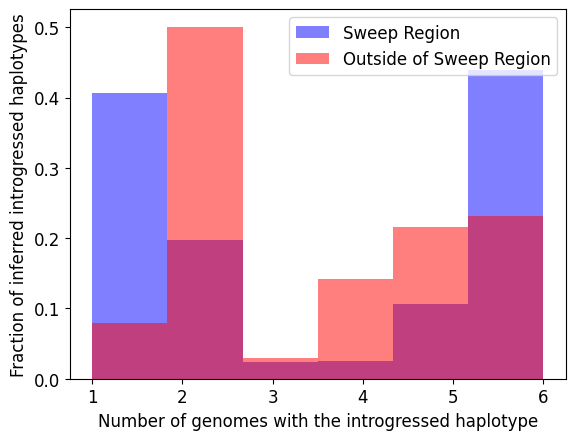

In [36]:
freqsForSweepType = {"Sweep Region": {}, "Other": {}}                   
for currArm, pos in introgFreqs:
    if currArm == "3R" and pos <= 4769900 and pos > 4539900:
        freqsForSweepType["Sweep Region"][(currArm, pos)] = introgFreqs[(currArm, pos)]
    else:
        freqsForSweepType["Other"][(currArm, pos)] = introgFreqs[(currArm, pos)]

for annotType in freqsForSweepType:
    freqs = list(freqsForSweepType[annotType].values())
    print(annotType, len(freqsForSweepType[annotType]), np.nanmean(freqs), len([x for x in np.isnan(freqs) if x]))
print("")
         
plt.hist([x for x in freqsForSweepType['Sweep Region'].values() if not np.isnan(x)], bins=6, density=True, alpha=0.5, label='Sweep Region', color='blue')
plt.hist([x for x in freqsForSweepType['Other'].values() if not np.isnan(x)], bins=6, density=True, alpha=0.5, label='Outside of Sweep Region', color='red')
plt.xlabel("Number of genomes with the introgressed haplotype", fontsize=12)
plt.ylabel("Fraction of inferred introgressed haplotypes", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Getting introgressed haplotype lengths at increasing distances from the center of the sweep region

In addition to having larger allele frequencies, we might also expect regions of recent adaptive introgression to have larger introgressed segments (because recombination had less time to break them up as they swept through the population). Let's see if that appears to be the case here:

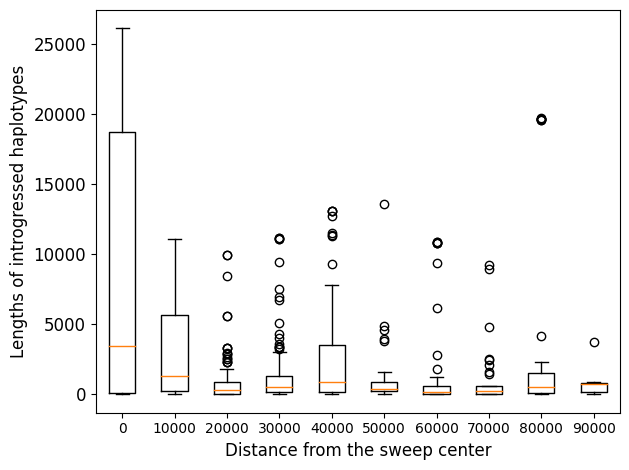

In [37]:
def getIntrogRuns(introgSnpIndices):
    indices = sorted(introgSnpIndices)
    runStart = indices[0]
    prevIndex = runStart
    runs = []
    
    for i in range(1, len(indices)):
        #print(i, indices[i], len(indices))
        if indices[i] == prevIndex + 1:
            prevIndex = indices[i]
        else:
            run = (positions[arm][runStart], positions[arm][prevIndex])
            runs.append(run)
            runStart = indices[i]
            prevIndex = runStart
    run = (positions[arm][runStart], positions[arm][prevIndex])
    runs.append(run)
    return runs
            

# this is the approximate location of the lowest-diversity region of the sweep
# (data from https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007341)
sweepSite = 4624900
arm = '3R'

dists = list(range(0, 100000, 10000))
hapLensInDistBin = []
for dist in dists:
    hapLensInDistBin.append([])

for sample in samples:
    runs = getIntrogRuns(introgAllelesInSample[arm][sample])
    for s, e in runs:
        d = min([abs(sweepSite-s), abs(sweepSite-e)])
        if d < 1e5:
            runL = e-s+1
            
            distBin = int(d / 1e4)
            hapLensInDistBin[distBin].append(runL)


bplot = plt.boxplot(hapLensInDistBin, labels=dists)
plt.xlabel("Distance from the sweep center", fontsize=12)
plt.ylabel("Lengths of introgressed haplotypes", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

for i in range(1, len(hapLensInDistBin)):
    sweepLens = hapLensInDistBin[0]
    currLens = hapLensInDistBin[i]

plt.tight_layout()
plt.savefig(f"introg_hap_lens_near_sweep.pdf")
plt.show()